# COST INTERACT ML Challenge (PHY) - Baseline

The code contained in this notebook serves as the baseline code provided by the organizers of the COST INTERACT ML challenge (PHY). The baseline implements a CNN model for direct positioning, originally presented in the original paper "CSI-based positioning in massive MIMO systems using convolutional neural networks", S. De Bast et. Al (link: https://ieeexplore.ieee.org/abstract/document/9129126). The baseline is provided as a starting point for participants to build upon.

Authors: Marco Skocaj (HA1 Chair, Università di Bologna, Italy), Nicola Di Cicco (Politecnico di Milano, Italy)

In [1]:
# Import libraries
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from build_model import build_model

# Check tensorflow version (tf <= 2.10 required for native gpu support on Windows)
print(tf.__version__)

# Check tf is running on gpu
print(tf.config.list_physical_devices('GPU'))

2024-09-22 15:22:20.449077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 15:22:20.534375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 15:22:20.561510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 15:22:20.742704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 15:22:22.775439: W tensorflow/compiler/tf2

2.17.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1726998745.115034   21028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726998745.363357   21028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726998745.364435   21028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
2+3

5

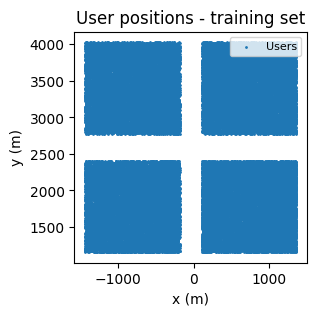

In [17]:
# Read user positions (labels) and antenna positions
y_train = np.load('../dataset/CSI_Y_ULA_lab_LoS_50000.npy')
# Plot 2D positions
plt.figure(figsize=(3, 3))
plt.scatter(y_train[:, 0], y_train[:, 1], s=1, label='Users')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('User positions - training set')
plt.show()

In [24]:
### Train model on training set ###
def process_complex(X_complex):
    X_real = np.real(X_complex)
    X_imag = np.imag(X_complex)
    return np.stack((X_real, X_imag), axis=-1)

# Read CSI training files from train folder
# print(f"Reading training files from {fpath_train}...")
# train_files = glob.glob(f"{fpath_train}/*.npy")

# Load all files into a np array
# X_train = np.array([process_complex(np.load(f)) for f in train_files])
X_complex = np.load('../dataset/CSI_X_ULA_lab_LoS_50000.npy')
X_train = np.stack((X_complex.real, X_complex.imag), axis=-1)
# X_train = np.array([process_complex(f) for f in X_complex])

print("Done!")
print("Training shape: ", X_train.shape)

Done!
Training shape:  (50000, 64, 100, 2)


In [25]:
X_train[0].shape

(64, 100, 2)

In [35]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras import regularizers
from keras.layers import Add, Concatenate, Conv3D, Dense, Dropout, Flatten, Input, Lambda, LeakyReLU, Multiply, Reshape
from keras.models import Model


### Utils ###
# def k_mean(tensor):
#     return K.mean(tensor, axis=2)


def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    import tensorflow as tf

    t = tf.math.atan2(tensor[0], tensor[1])
    return t


def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)


### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 6
    nn_input = Input((64, 100, 2))

    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0], output_shape=(None, 64, 100))(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1], output_shape=(None, 64, 100))(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt, output_shape=(None, 64, 100))(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(type(r))
    print(r.shape)
    # print(r.get_shape())

    # phase
    t = Lambda(k_atan, output_shape=(None, 64, 100))([imag, real])
    t = Reshape((64, 100, 1))(t)
    # print(t.get_shape())

    polar_input = Concatenate()([r, t])

    time_input = Lambda(ifft)(nn_input)

    total_input = Concatenate()([nn_input, polar_input, time_input])
    print("total", total_input.shape)

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same")(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same")(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same")(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same", kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same")(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same")(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same", kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same")(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same")(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same")(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same", kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same")(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same")(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same")(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    # NEW
    nn_output = Dense(1024, activation="relu")(nn_output)
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model


In [36]:
X_train[::5].shape

(10000, 64, 100, 2)

<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
(None, 64, 100, 1)
total (None, 64, 100, 6)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 100,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_20 (Lambda)  │ (None, None, 64,  │          0 │ input_layer_4[0]… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, None, 64,  │          0 │ input_layer_4[0]… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, None, 64,  │          0 │ lambda_20[0][0],  │
│ (Multiply)          │ 100)              │            │ lambda_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, None, 64,  │          0 │ lambda_21[0][0],  │
│ (Multiply)          │ 100)              │            │ lambda_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64,  │          0 │ multiply_8[0][0], │
│                     │ 100)              │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_22 (Lambda)  │ (None, None, 64,  │          0 │ add_4[0][0]       │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_23 (Lambda)  │ (None, None, 64,  │          0 │ lambda_21[0][0],  │
│                     │ 100)              │            │ lambda_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 64, 100,   │          0 │ lambda_22[0][0]   │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 64, 100,   │          0 │ lambda_23[0][0]   │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 64, 100,   │          0 │ reshape_12[0][0], │
│ (Concatenate)       │ 2)                │            │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_24 (Lambda)  │ (None, 64, 100,   │          0 │ input_layer_4[0]… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 64, 100,   │          0 │ input_layer_4[0]… │
│ (Concatenate)       │ 6)                │            │ concatenate_36[0… │
│                     │                   │            │ lambda_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 64, 100,   │          0 │ concatenate_37[0… │
│ (Reshape)           │ 6, 1)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_56 (Conv3D)  │ (None, 64, 20, 6, │      1,112 │ reshape_14[0][0]  │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, 64, 20, 6, │          0 │ conv3d_56[0][0]   │
│ (LeakyReLU)         │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,233,058 (12.33 MB)

 Trainable params: 3,233,058 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2024-09-22 16:00:38.740261: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4375', 180 bytes spill stores, 180 bytes spill loads

2024-09-22 16:00:39.688530: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5112', 40 bytes spill stores, 40 bytes spill loads



186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1543820.3750

2024-09-22 16:00:59.719834: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4375', 180 bytes spill stores, 180 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1537817.7500

2024-09-22 16:01:12.465992: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_299', 4 bytes spill stores, 4 bytes spill loads

2024-09-22 16:01:12.819494: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_299', 200 bytes spill stores, 200 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - loss: 1534862.8750 - val_loss: 750604.0625
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 723040.8750 - val_loss: 309482.7812
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 211117.3594 - val_loss: 107321.8203
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 117030.6797 - val_loss: 155864.7344
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 91114.8203 - val_loss: 92025.4531
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 81502.8047 - val_loss: 71189.6094
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 69598.5000 - val_loss: 52160.9023
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 57745.9336 - val_loss: 43111.3672
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 54385.1172 - val_loss: 52309.1289
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 49873.4375 - val_loss: 39351.3047
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━

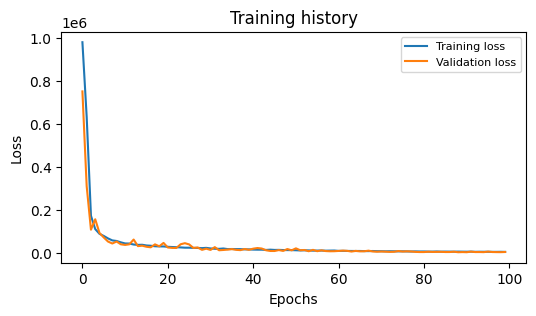

In [37]:
# Build and compile model
model = build_model()

# Train model
history = model.fit(X_train[:15000], y_train[:15000], epochs=100, batch_size=64, validation_split=0.2)

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

1084/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2024-09-22 16:54:45.377543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_262', 200 bytes spill stores, 200 bytes spill loads



1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


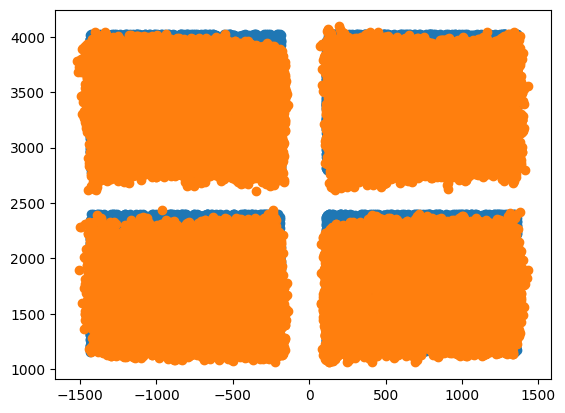

In [38]:
y_pred = model.predict(X_train[15000:])

plt.scatter(y_train[15000:, 0], y_train[15000:, 1])
plt.scatter(y_pred[:, 0], y_pred[:, 1])

plt.show()

In [39]:
tf.keras.backend.clear_session()

In [47]:
del model

In [40]:
import gc
gc.collect()

0